Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

3.	For extra credit, analyze sentiment of chunks as follows:
a.	Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).
b.	Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 
Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings. 


In [14]:
import nltk 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
from bs4 import BeautifulSoup
from requests import get
import selenium
from selenium import webdriver 
import requests
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from statistics import mean, median
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


In [15]:
url = 'https://www.imdb.com/list/ls095374765/?sort=moviemeter,asc&st_dt=&mode=grid&page=1&ref_=ttls_vw_smp&genres=Thriller'
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')

movieReview = []
reviewTitle = []
movieTitle = []
stop_words = set(stopwords.words("english"))

In [16]:
def list_Of_Reviews(website):
    soup = BeautifulSoup(website, 'html.parser')
    # print(soup)
    f = soup.find_all('div', class_='ipl-icon ipl-star-icon')
    f = soup.find_all('span', class_="rating-other-user-rating")#.find('span').text

    idxPos = -1
    idxNeg = -1

    for idx, i in enumerate(f):
        sp = (f[idx].text.split('/'))
        sp = int(sp[0][-2:])
        if sp > 8:
            idxPos = idx
        elif sp < 4:
            idxNeg = idx
    return([idxNeg,idxPos])

In [17]:
for div in html_soup.findAll('div', attrs={'class':'title'}):
    if len(movieReview) > 100:
        break
    else:
        url = 'https://www.imdb.com' + div.find('a')['href'] 
        url = url + 'reviews'
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        review_containers = html_soup.find_all('div', class_='text show-more__control')
        title_containers = html_soup.find_all( class_='title')
        
        reviewIndex = list_Of_Reviews(response.content)
        reviewList = []

        if reviewIndex[0] == -1 or reviewIndex[1] == -1:
            pass
        else:
            reviewList.append(review_containers[reviewIndex[0]].text)
            reviewList.append(review_containers[reviewIndex[1]].text)
            reviewTitle.append(title_containers[reviewIndex[0]].string)
            reviewTitle.append(title_containers[reviewIndex[1]].string)
            movieTitle.append(div.string)
            movieTitle.append(div.string)
            count =+ 2
            for i in reviewList:
                review = i.lower()
                #remove punctuation
                review = re.sub('[^a-zA-Z]', ' ', review)
                
                #remove tags
                review = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",review)

                #remove special characters and digits
                review = re.sub("(\\d|\\W)+"," ",review)

                split_text = review.split()
                
                #Lemmatisation
                lem = WordNetLemmatizer()
                split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
                split_text = " ".join(split_text)
                movieReview.append(split_text)

In [18]:
#I am going to use TfidfVectorizer this time
vectorizer = TfidfVectorizer(stop_words={'english'})
movieList_v = vectorizer.fit_transform(movieReview)

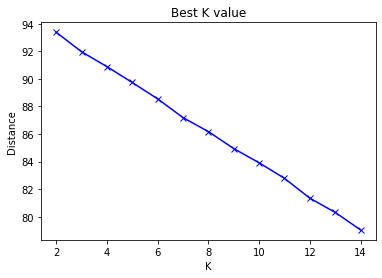

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
X = movieList_v
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Distance')
plt.title('Best K value')
plt.show()

In [20]:
k = 8
model = KMeans(n_clusters=k, max_iter=200, n_init=10, tol = 0.001)
mod_8 = model.fit(X)
labels=model.labels_

review_clusters = pd.DataFrame(list(zip(movieTitle, labels)),columns=['Movie Title','Cluster'])
print(review_clusters.sort_values(by=['Cluster']))

                         Movie Title  Cluster
17                          WarGames        0
78                        Nighthawks        0
54        The Taking of Pelham 1 2 3        0
74                Surviving the Game        0
42               The Next Three Days        0
..                               ...      ...
92  Darkman II: The Return of Durant        7
93  Darkman II: The Return of Durant        7
50                         RoboCop 3        7
64                       The Hitcher        7
79                        Nighthawks        7

[100 rows x 2 columns]


In [21]:
common_words = mod_8.cluster_centers_.argsort()[:,-1:-10:-1]

word_features = vectorizer.get_feature_names_out()

for cluster_group, centroid in enumerate(common_words):
    print(f"Cluster {cluster_group}: {', '.join(word_features[word] for word in centroid)}")

Cluster 0: movie, also, action, game, play, really, character, stupid, computer
Cluster 1: movie, film, scene, one, action, make, time, first, ever
Cluster 2: batman, segment, dark, animated, movie, knight, voice, film, part
Cluster 3: girl, cletus, get, terrorist, old, ferris, eddie, phone, younger
Cluster 4: washington, denzel, movie, day, performance, good, john, oscar, credit
Cluster 5: zorro, good, movie, identity, elena, zeta, bandaras, fashioned, hopkins
Cluster 6: dream, woman, wonder, western, picture, people, many, villain, opinion
Cluster 7: robocop, film, first, darkman, action, neeson, nothing, sequel, played


In [27]:
result={'cluster':labels,'Movie Reviews':movieReview}
result=pd.DataFrame(result)

In [22]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\drsco\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:

SentiAnalyzer = SentimentIntensityAnalyzer()

stopWords = stopwords.words("english")
stopWords.extend([w.lower() for w in nltk.corpus.names.words()])

In [24]:


def polarity_score(review):
    scores = [
      SentiAnalyzer.polarity_scores(sentence)["compound"]
        for sentence in [w for w in nltk.sent_tokenize(review) if not w in stopWords]
    ]
    return mean(scores)

In [26]:
#let us use some country music songs to help us determine polarity score
polarity_score('I like my beer ice cold but I will drink them warm')

0.4767

In [28]:
polarityScore = []
for review in movieReview:
    score = polarity_score(review)
    polarityScore.append(score)

result['Score'] = polarityScore
print(result)

    cluster                                      Movie Reviews   Score
0         1  right praise hype movie joker director todd ph...  0.9861
1         3  section new york new jersey standing gotham ci...  0.8898
2         4  movie bad like frankly fun tom hardy suit role...  0.9825
3         3  thoroughly disappointed venom let carnage botc... -0.9937
4         3  movie begin see liam neeson matt scudder polic...  0.6240
..      ...                                                ...     ...
95        3  nothing brag like twisted bloody story reached... -0.9654
96        3  good idea bad feeling could much said geared y...  0.6369
97        1  amazed technology intelligence meaning scienti...  0.9643
98        1  suppose phantom might passable entertainment s...  0.8701
99        3  phantom solidly entertaining unspectacular sub...  0.9860

[100 rows x 3 columns]


In [29]:
cluster_Scores = result[['cluster','Score']]
cluster_Group_Scores = cluster_Scores.groupby("cluster").agg({'Score': ['mean', 'median', 'min', 'max']})
print(cluster_Group_Scores)

            Score                         
             mean   median     min     max
cluster                                   
0        0.333708  0.88000 -0.9705  0.9926
1        0.534003  0.89480 -0.9906  0.9872
2        0.197192  0.81305 -0.9852  0.9838
3       -0.073750 -0.08025 -0.9937  0.9860
4        0.550892  0.96610 -0.9758  0.9889
5        0.083050  0.23690 -0.9863  0.9948
6        0.438387  0.85170 -0.9590  0.9946
7        0.143400  0.64860 -0.9926  0.9978


### Clusters

In total we can see that we have 8 clusters. looking at them we have 1 that had a negitive mean score with two that I would consider neutral. Overall most of them seem to be positive besides cluser 4.\
However we also see that the min and max of these clusers are very polarising since some are very high (almost 1) and every low (almost -1). This shows that clustering on this data set in this way may not be the best solution.